# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [3]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# !unzip Train_rev1.zip
data = pd.read_csv("/content/drive/MyDrive/xyita/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [4]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

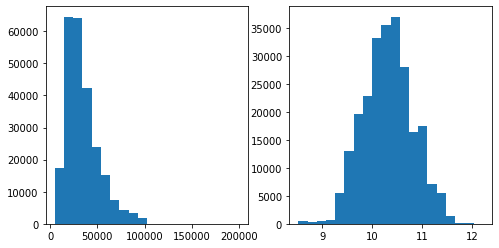

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
40425,68360422,Senior SharePoint/ Net Developer Bermuda US$...,About the Client We are recruiting for a leadi...,UK,UK,NaN,permanent,CML Offshore Recruitment,IT Jobs,"From 50,000 to 60,000 per annum low tax of 5.2...",55000,cwjobs.co.uk,10.915107
82781,69042212,Customer Service Officer,"At RBS, the vision of UK Retail (including the...",Woking,Woking,NaN,NaN,RBS,Accounting & Finance Jobs,"From 22,012 pro rata package including benefits",22012,MyUkJobs,9.999389
196961,71830160,"Finance Associate, Private Equity",My client is a well established global Private...,London,London,NaN,NaN,Hays Financial Markets,Accounting & Finance Jobs,GBP50000.00 - GBP60000.00 per annum + Bonus + ...,55000,eFinancialCareers,10.915107


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [7]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [8]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [9]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [11]:
  print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


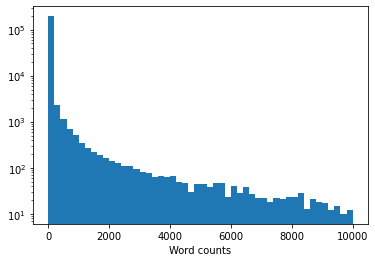

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [19]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [21]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
        
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [22]:
make_batch(data_train[:3], max_len=10)

{'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631]),
 'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [23]:
import torch
import torch.nn as nn
import torch.functional as F

In [24]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [25]:
model = SalaryPredictor()

In [26]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [27]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [28]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cuda')

In [29]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    return mse, mae

In [30]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
  print(f"epoch: {epoch}")
for i, batch in tqdm.notebook.tqdm(enumerate(
    iterate_minibatches(
                     data_train, 
                     batch_size=BATCH_SIZE, 
                     device=DEVICE)), 
                 total=len(data_train) // BATCH_SIZE
         ):
         model.train()
         pred = model(batch)
         optimizer.zero_grad()
         loss = criterion(pred, batch[TARGET_COLUMN])
         loss.backward()
         optimizer.step()

         if i % 100 == 99:
             print('train_loss', loss.item())
             print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0
epoch: 1
epoch: 2


train_loss 8.4630708694458
train_loss 0.44725656509399414
train_loss 0.31949713826179504
train_loss 0.31402045488357544
train_loss 0.293408066034317
train_loss 0.28752565383911133
train_loss 0.2113809436559677
train_loss 0.2557247281074524
train_loss 0.1873934417963028
train_loss 0.30101701617240906
train_loss 0.1888602077960968
train_loss 0.23451094329357147
train_loss 0.18539446592330933
train_loss 0.23448726534843445
train_loss 0.1959485411643982
train_loss 0.143663227558136
train_loss 0.18450927734375



# Лабораторная работа № 1. Обработка естественного языка.

### Резюме




#### Первая часть
  Пробовал BatchNorm, добавление одного и нескольких дополнительных свёрточных слоёв, параллельные свёрточные слои и всё вместе в разных комбинациях.
#### Вторая часть
  Попробовал заменить AdaptiveMaxPool1d на AdaptiveAvgPool1d.
#### Третья часть
  Попробовал использовать предобученные в твиттере модели. Так же опробовал заморозить веса в embedding.
#### Четвёртая часть
  Попробовал разные виды рекуррентых слоёв. 

## Задание 1

In [31]:
def model_plots(mse, mae, loss):
  plt.figure(figsize=(10, 7))
  plt.plot(mse[1:], color='green', label='MSE')
  plt.plot(mae[1:], color='blue', label='MAE')
  plt.plot(loss[1:], color='red', label='loss')
  plt.xlabel('Epochs')
  plt.ylabel('Metrics')
  plt.legend()
  plt.show()

In [32]:
def early_stop(mse_loss, epsilon):
  if abs(mse_loss[-1] - mse_loss[-2]) > epsilon:
    return False
  return True  

In [33]:
def train_test_model(model, criterion, optimizer, epsilon=0.003, max_epochs=20):
  mse, mae, los = [], [], []

  for epoch in range(max_epochs):
      print(f"epoch: {epoch}")
      for i, batch in tqdm.notebook.tqdm(enumerate(
              iterate_minibatches(
                      data_train, 
                      batch_size=BATCH_SIZE, 
                      device=DEVICE)), 
                  total=len(data_train) // BATCH_SIZE
          ):
          model.train()
          pred = model(batch)
          # print(pred)
          optimizer.zero_grad()
          loss = criterion(pred, batch[TARGET_COLUMN])
          loss.backward()
          optimizer.step()
          if i % 860 == 1:
              # print('train_loss', loss.item())
              los.append(loss.item())
              mse_0, mae_0 = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
              mse.append(mse_0)
              mae.append(mae_0)
      if early_stop(mse, epsilon):
        break
      print('MSE: ', mse[-1]) 
      print('MAE: ', mae[-1])
      print('Loss: ', los[-1])

  model_plots(mse[2:], mae, los)
  print('MSE: ', mse[-1]) 
  print('MAE: ', mae[-1])
  print('Loss: ', los[-1])

In [34]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=4),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=3),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=2),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

epoch: 0



MSE:  0.290199875831604
MAE:  0.2508512536684672
Loss:  1.2138659954071045
epoch: 1



MSE:  0.05690562725067139
MAE:  0.09573786457379659
Loss:  0.06787164509296417
epoch: 2


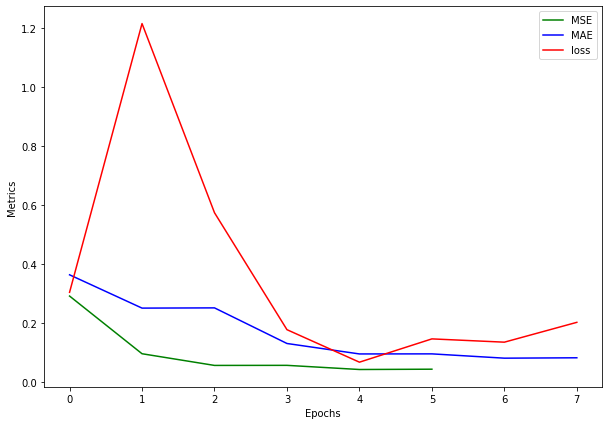

MSE:  0.04412942131360372
MAE:  0.08274353543917339
Loss:  0.20272426307201385


In [35]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_test_model(model, criterion, optimizer)

### Вывод
Добавление BatchNorm значительного прироста не дало. Добавление 2 сверточных слоёв для работы с текстом дало значительный прирост(если добавлять без Batch Norm и пулинга, то прирост не такой большой). Добавление 1 свёрточного слоя в title_encoder не дало больших результатов. В description_encoder хватило одного доп слоя, чтобы поднять результат, остальные сильно не повлияли. Параллельные слои тоже дали прирост, но не такой сильный как просто добавление доп слоёв. Параллельные + доп слои даль ещё меньший прирост, чем предыдущие варианты.


## Задание 2

Проходясь непересекающимися окнами по карте признаков заменяет группы значений на единственное. По сути убирает излишнюю подробность "изображения", позволяет сфокусироваться на важных деталях.


In [ ]:
class SalaryPredictor_avg(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=4),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=3),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=2),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1)
        )
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

epoch: 0



MSE:  0.036491841077804565
MAE:  0.07465698321660359
Loss:  0.10484855622053146
epoch: 1



MSE:  0.038306000332037606
MAE:  0.07763806978861491
Loss:  0.20547740161418915
epoch: 2



MSE:  0.05124152700106303
MAE:  0.0939372976620992
Loss:  0.40174269676208496
epoch: 3



MSE:  0.04148764659961065
MAE:  0.08267456293106079
Loss:  0.13479530811309814
epoch: 4



MSE:  0.03924956421057383
MAE:  0.07985017697016399
Loss:  0.07408914715051651
epoch: 5


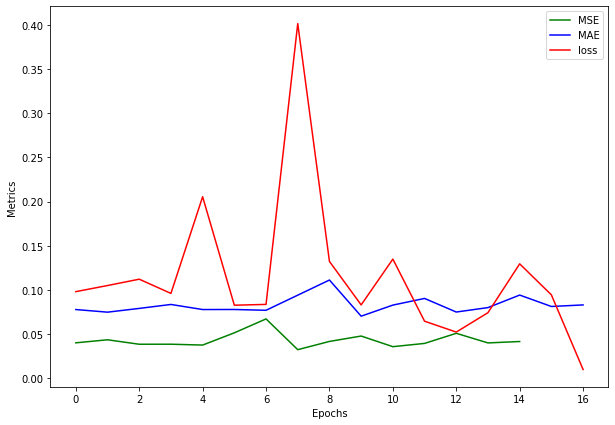

MSE:  0.0413962130745252
MAE:  0.08287244041760762
Loss:  0.009677363559603691


In [ ]:
model = SalaryPredictor_avg().to(DEVICE)
train_test_model(model, criterion, optimizer)

###Вывод

Модель с AVG пулингом дольше обучалась и показали примерно такой же результат.

## Задание 3

In [ ]:
import gensim.downloader as api

gensim_model = api.load("glove-twitter-50") 

[==================================================] 100.0% 199.5/199.5MB downloaded


epoch: 0



MSE:  0.1082694133122762
MAE:  0.15293877323468527
Loss:  0.8755158185958862
epoch: 1



MSE:  0.10048851370811462
MAE:  0.14652563134829202
Loss:  0.08613215386867523
epoch: 2



MSE:  0.09782644112904866
MAE:  0.14451988538106283
Loss:  0.2819180488586426
epoch: 3



MSE:  0.0905348261197408
MAE:  0.13806752363840738
Loss:  0.05394335091114044
epoch: 4



MSE:  0.08229558169841766
MAE:  0.13078981637954712
Loss:  0.06310945749282837
epoch: 5



MSE:  0.1124099890391032
MAE:  0.1561967134475708
Loss:  0.3704109191894531
epoch: 6



MSE:  0.10092967748641968
MAE:  0.14710715413093567
Loss:  0.1680762618780136
epoch: 7


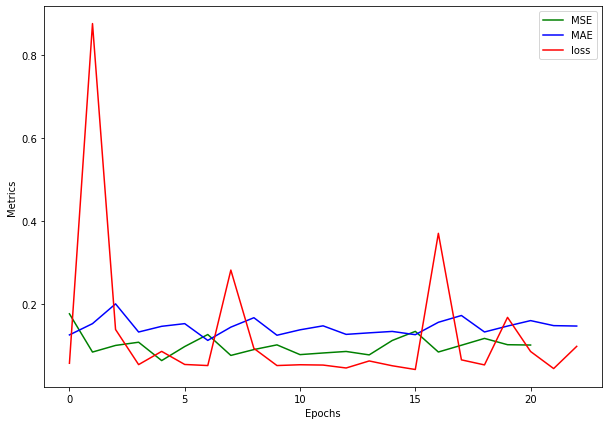

MSE:  0.10141060749689738
MAE:  0.1471539338429769
Loss:  0.09824125468730927


In [ ]:
model1 = SalaryPredictor().to(DEVICE)
model1.embedder.from_pretrained(torch.FloatTensor(gensim_model.vectors))
train_test_model(model, criterion, optimizer)

epoch: 0



MSE:  0.0922495424747467
MAE:  0.13960551222165427
Loss:  0.14040198922157288
epoch: 1


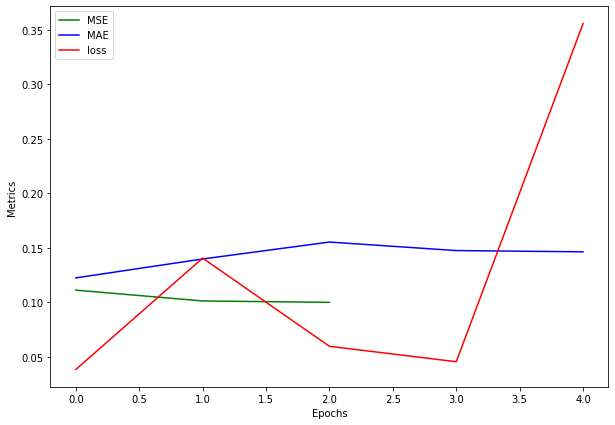

MSE:  0.09980165958404541
MAE:  0.14617461959520975
Loss:  0.3556452691555023


In [ ]:
model2 = SalaryPredictor().to(DEVICE)
model2.embedder.from_pretrained(torch.FloatTensor(gensim_model.vectors))
model2.embedder.requires_grad = False
train_test_model(model, criterion, optimizer)

Модель с предобученными весами показала не такой хороший результат, как модель с рандомными весами. Модель с замороженными показала примерно такой же результат как и и модель с просто предобученными.

## Задание 4

In [ ]:
class SalaryPredictor_lstm1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.LSTM(hid_size, 4),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=3),
            nn.LSTM(hid_size, 3),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=2),
            nn.LSTM(hid_size, 2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.description_encoder = nn.Sequential(
            nn.LSTM(hid_size, 2),
            nn.BatchNorm1d(hid_size),
            nn.LSTM(hid_size, 3),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
class SalaryPredictor_lstm2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.LSTM(hid_size, 4, bidirectional=True),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=3),
            nn.LSTM(hid_size, 3, bidirectional=True),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=2),
            nn.LSTM(hid_size, 2, bidirectional=True),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.description_encoder = nn.Sequential(
            nn.LSTM(hid_size, 2, bidirectional=True),
            nn.BatchNorm1d(hid_size),
            nn.LSTM(hid_size, 3, bidirectional=True),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

epoch: 0



MSE:  0.11750122904777527
MAE:  0.16025455792744955
Loss:  0.13456368446350098
epoch: 1



MSE:  0.08064509928226471
MAE:  0.12936758995056152
Loss:  0.06360435485839844
epoch: 2



MSE:  0.1039345661799113
MAE:  0.14965122938156128
Loss:  0.03946640342473984
epoch: 3



MSE:  0.13181471824645996
MAE:  0.17104365428288779
Loss:  0.8974426984786987
epoch: 4



MSE:  0.1350101629892985
MAE:  0.17343672116597494
Loss:  0.2616778016090393
epoch: 5



MSE:  0.10097421209017436
MAE:  0.14704543352127075
Loss:  0.03242270275950432
epoch: 6



MSE:  0.10069851080576579
MAE:  0.14676788449287415
Loss:  0.09662993997335434
epoch: 7



MSE:  0.10852222641309102
MAE:  0.1534127096335093
Loss:  0.030976302921772003
epoch: 8


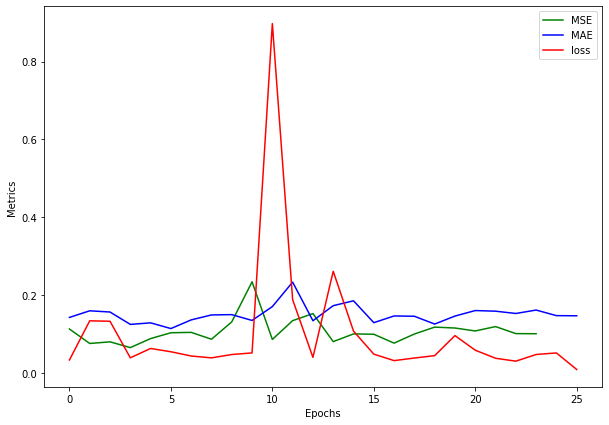

MSE:  0.10140519340833028
MAE:  0.14743614196777344
Loss:  0.009611796587705612


In [ ]:
model3 = SalaryPredictor_lstm1().to(DEVICE)
train_test_model(model, criterion, optimizer)

epoch: 0



MSE:  0.13884780804316202
MAE:  0.176112433274587
Loss:  0.33533692359924316
epoch: 1



MSE:  0.1458680828412374
MAE:  0.18104737997055054
Loss:  0.5179733037948608
epoch: 2


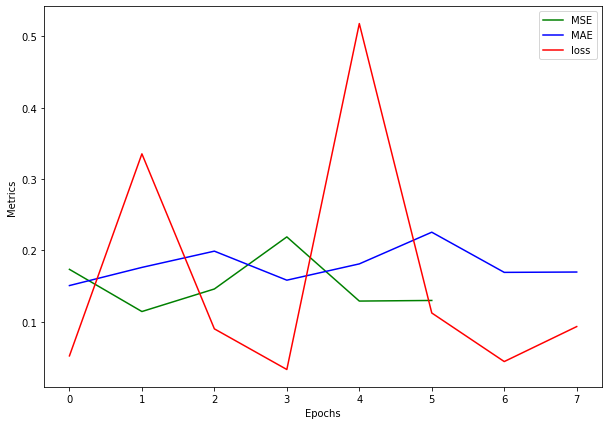

MSE:  0.12977168957392374
MAE:  0.16962456703186035
Loss:  0.09314487874507904


In [ ]:
model4 = SalaryPredictor_lstm2().to(DEVICE)
train_test_model(model, criterion, optimizer)

### Вывод
Однонаправленная оказалась лучше.


## Задание 5


In [84]:
from sklearn.ensemble import RandomForestRegressor

class SalaryPredictor_forest():
    def __init__(self, model, forest):
        self.model = SalaryPredictor()
        self.model.load_state_dict(model.state_dict())
        #self.model.eval()
        if len(self.model.final_predictor) > 2 :
            del self.model.final_predictor[2]
        self.forest = forest
        
    def fit(self, x, y):
        pred = self.model(x)
        self.forest.fit(pred.detach().numpy(), y)
    
    #def eval(self):
        #pass
    
    def __call__(self, x):
        pred = self.model(x)
        return torch.Tensor(self.forest.predict(pred))

def train_forest_model(model):
    for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=None)), 
                    total=len(data_train) // BATCH_SIZE
            ):
        model.fit(batch, batch['Log1pSalary'])

In [85]:
forest = RandomForestRegressor(n_estimators=10)
model_forest = SalaryPredictor_forest(model, forest)
train_forest_model(model_forest)

In [87]:
metrics = print_metrics(model_forest, data_val, name='forest', batch_size=BATCH_SIZE, device=None) 

print('mse:', metrics[0])
print('mae:', metrics[1])

mse: 0.2140906055768331
mae: 0.19992905855178833


### Вывод
Результат оказался очень плохим